In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# Set up folder with data:
os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [3]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [6]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [7]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = ['hour','week']
LagList = None

In [8]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [9]:
###################
#%% '01' model on summer time
###################

In [10]:
AnalysisData_01 = AnalysisData.loc[:'2019-07']   

In [11]:
TestSetDate_01 = '2019-02'

In [12]:
# Prepare Data For ANN
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_sld_01, y_Train_sld_01,\
X_Test_sld_01, y_Test_sld_01,\
scaler_X_01, scaler_y_01 = \
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = None,     
                                     ScalerType = 'Standard',
                                     ScalerRange = None,                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_01 = AnalysisData.loc[y_Test_sld_01.index][['Demand']]

In [13]:
###################
#%% '02' model on winter time
###################

In [14]:
AnalysisData_02 = AnalysisData.loc[:'2020-02']

In [15]:
TestSetDate_02 = '2019-09'

In [16]:
# Prepare Data for ANN
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_sld_02, y_Train_sld_02,\
X_Test_sld_02, y_Test_sld_02,\
scaler_X_02, scaler_y_02 = \
            PrepareDataForRegression(X_02, y_02, 
                                     TestSplitInd = TestSetDate_02,
                                     ValSplitInd = None,     
                                     ScalerType = 'Standard',
                                     ScalerRange = None,                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_02 = AnalysisData.loc[y_Test_sld_02.index][['Demand']]

In [17]:
##########################################################
##########################################################
#%% FIT MODEL - hyperparameter tuning
##########################################################
##########################################################

In [18]:
# Define parameters set
svm_param_grid = {
                  #'kernel': ['rbf','poly'],
                  'kernel': ['rbf'],
                  'C': [12, 10, 8,  5, 3,  1, 0.1, 0.05],
                  'gamma': [0.05, 0.01, 0.005, 0.001, 0.0005],
                  'epsilon': [0.5, 0.3, 0.1, 0.08],
                  #'degree':[3,4]
                 }

In [19]:
###################
#%% '01' model on summer time
###################

In [20]:
# Instantiate the regressor: svr
svr = svm.SVR()

# Perform random search with CV for time series
SVRmodel_RandomSearch_01 = RandomizedSearchCV(param_distributions = svm_param_grid,
                                              estimator = svr,
                                              scoring = "neg_mean_squared_error",
                                              n_iter = 50,
                                              cv = TimeSeriesSplit(n_splits=8).split(X_Train_sld_01),
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
SVRmodel_RandomSearch_01.fit(X_Train_sld_01, y_Train_sld_01)

# Print the best parameters
print("Best parameters found: ", SVRmodel_RandomSearch_01.best_params_)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


C:\Users\kamil\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:  {'kernel': 'rbf', 'gamma': 0.001, 'epsilon': 0.3, 'C': 12}


In [21]:
# Extract the best model
Final_Model_01 = SVRmodel_RandomSearch_01.best_estimator_

In [22]:
###################
#%% '02' model on winter time
###################

In [23]:
Final_Model_02 = svm.SVR()
Final_Model_02.set_params(**SVRmodel_RandomSearch_01.best_params_)
Final_Model_02.fit(X_Train_sld_02, y_Train_sld_02)

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=12, epsilon=0.3, gamma=0.001)

In [24]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [25]:
###################
#%% test '01' model on summer time
###################

In [26]:
# Make prediction on test set
yhat_Test_SVR_01, X_Test_SVR_01 = \
     MakeTSforecast(X_Test_sld_01,\
                    Model = Final_Model_01,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_01,\
                    Scaler_X = scaler_X_01,\
                    Test_or_Forecast = 'Test')

    
DataWithPrediction_01 =\
    MakeANNfinalData(Model = Final_Model_01,\
                     Train_X_Scaled = X_Train_sld_01,\
                     Val_X_Scaled = None,\
                     Scaler_y = scaler_y_01,\
                     MainDF = AnalysisData_01,\
                     yhat_Test_DF = yhat_Test_SVR_01,\
                     yhat_Forecast_DF = None)

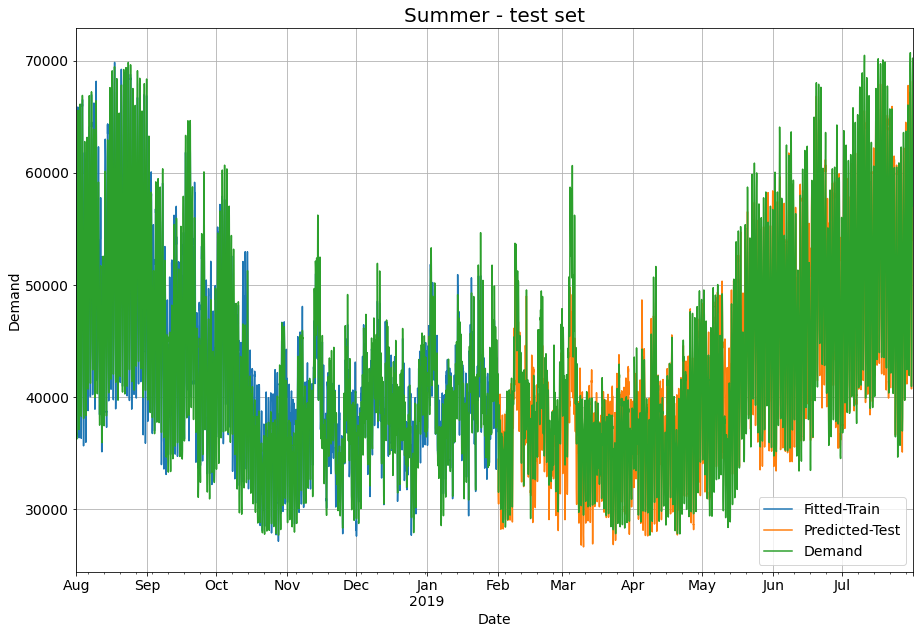

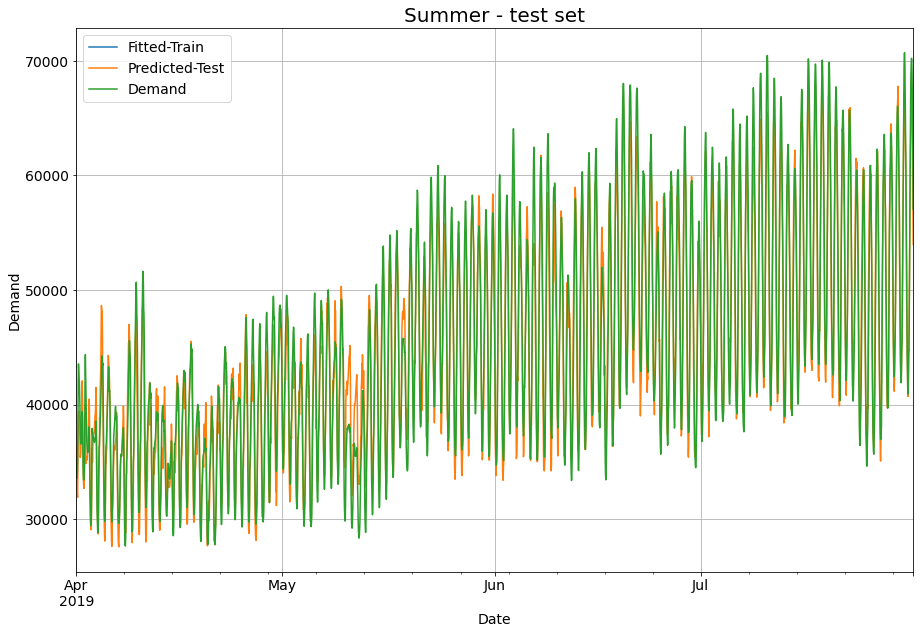

In [33]:
# Plot Fitted Data
DataWithPrediction_01[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2018-08':].plot()
                

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()



DataWithPrediction_01[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2019-04':].plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [28]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_SVR_01, X_Test_sld_01, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_SVR_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_SVR_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_SVR_01)),2)}' )

R2: 0.9335
R2_adj: 0.9322
(0.9335, 0.9322)

MAE:  1844.92
MAPE: 4.31
RSME: 2429.77


In [29]:
###################
#%% test '02' model on winter time
###################

In [30]:
# Make prediction on test set
yhat_Test_SVR_02, X_Test_SVR_02 = \
     MakeTSforecast(X_Test_sld_02,\
                    Model = Final_Model_02,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_02,\
                    Scaler_X = scaler_X_02,\
                    Test_or_Forecast = 'Test')

    
DataWithPrediction_02 =\
    MakeANNfinalData(Model = Final_Model_02,\
                     Train_X_Scaled = X_Train_sld_02,\
                     Val_X_Scaled = None,\
                     Scaler_y = scaler_y_02,\
                     MainDF = AnalysisData_02,\
                     yhat_Test_DF = yhat_Test_SVR_02,\
                     yhat_Forecast_DF = None)

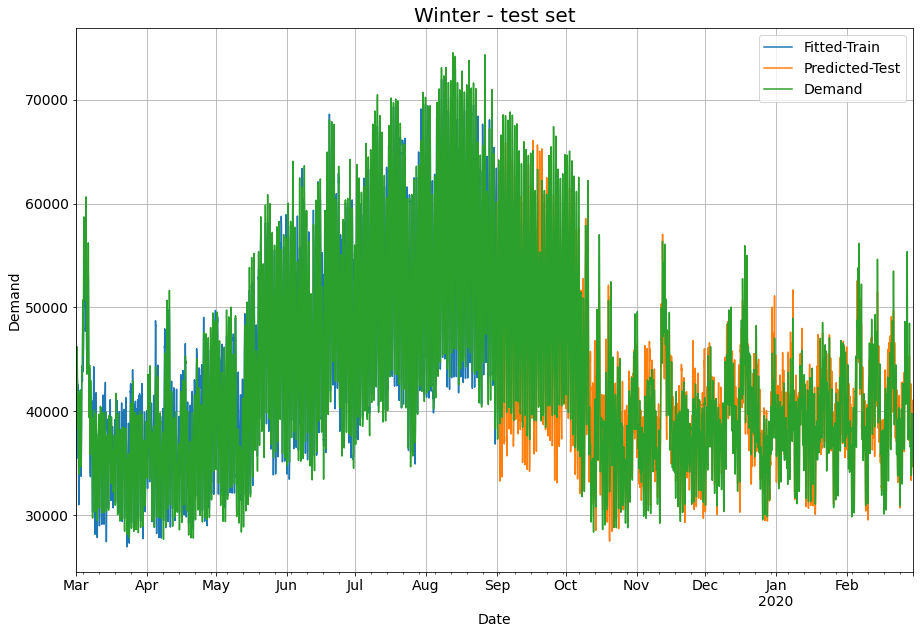

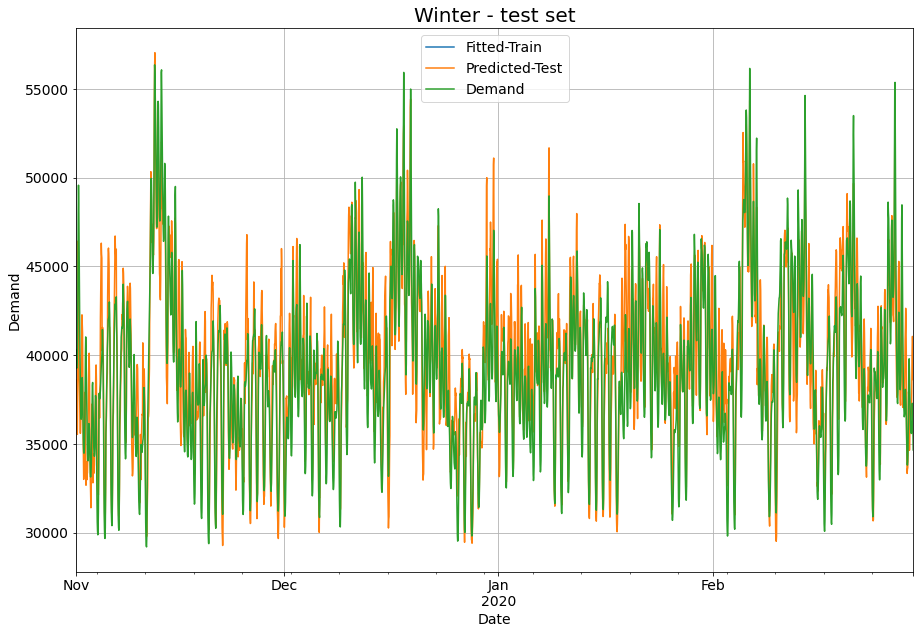

In [31]:
# Plot Fitted Data
DataWithPrediction_02[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                                .loc['2019-03':].plot()       
        

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()




DataWithPrediction_02[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2019-11':].plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [32]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_SVR_02, X_Test_sld_02, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_SVR_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_SVR_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_SVR_02)),2)}' )

R2: 0.9083
R2_adj: 0.9065
(0.9083, 0.9065)

MAE:  1839.57
MAPE: 4.44
RSME: 2362.55
